<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/time-series-analysis/big_portfolio_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner

### Team members: Steven Brooks & Chenlia Xu

In [1]:
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [2]:
## If boto3 not already installed uncomment the following:
!pip3 install boto3

     |████████████████████████████████| 131 kB 27.5 MB/s 
     |████████████████████████████████| 8.4 MB 10.3 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 138 kB 44.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')

In [4]:
%%capture

in_dir = "stock_data"
if not os.path.exists(in_dir):
  os.makedirs(in_dir)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty


tech_dir = "technical_data"
if not os.path.exists(tech_dir):
  os.makedirs(tech_dir)
!unzip /content/technical_data.zip -d /content/$tech_dir
!rm -f $tech_dir/.gitempty

# Section 1: Exploratory Data Analysis of the Stock Data

The schema of the stock data is as below:

In [5]:
import random
stock_data_files = os.listdir(in_dir)

# head of a random file
pd.read_csv(os.path.join(in_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,CSAN-W,2021-03-10,15.80,15.94,15.25,15.85,15.85,187681,0.0,1.0
1,CSAN-W,2021-03-09,15.35,15.60,14.99,15.25,15.25,373199,0.0,1.0
2,CSAN-W,2021-03-08,15.80,16.30,15.10,15.75,15.75,343925,0.0,1.0


### Step 0: Inspect the data

First look at the number of rows of data across within each year for each stock.  

In [13]:
def add_year_month_cols(df: pd.DataFrame, timestamp_col: str) -> pd.DataFrame:
  """ 
  Assumes the input df has a column that needs to be converted into datetime
  using datetime.strptime function and "%Y-%m-%d" format
  """
  new_col_name = timestamp_col + '_as_dt'
  df[new_col_name] = df[timestamp_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
  if len(df[new_col_name].unique()) != len(df[timestamp_col].unique()):
    raise Exception("error in timestamp parsing")
  df['year'] = pd.to_numeric(df[new_col_name].dt.year)
  df['month'] = pd.to_numeric(df[new_col_name].dt.month)
  return df

In [7]:
rows_per_year = dict()

for data_file in stock_data_files:
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_month_cols(stock_data, "timestamp")
  rows_per_year[data_file] = dict(stock_data.groupby(by = 'year').size())

print({k: rows_per_year[k] for k in list(rows_per_year)[:3]})

{'SRZNW.csv': {2021: 80}, 'USPH.csv': {1999: 43, 2000: 252, 2001: 248, 2002: 252, 2003: 252, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'EVT.csv': {2003: 67, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'PROCW.csv': {2021: 46}, 'OPP-P-B.csv': {2021: 12}, 'ABEV.csv': {1999: 43, 2000: 252, 2001: 248, 2002: 252, 2003: 252, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'NSS.csv': {2013: 234, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'LEVI.csv': {2019: 198, 2020: 253, 2021: 233}, 'NEPH.csv'

#### We'll just look at the data from the years we are interested in: 2002 to 2019.

In [8]:
analysis_years = range(2002, 2020)

27 stocks have data in each of the years in range(2002, 2020)
There are 4 unique rows-per-year patterns among those stocks


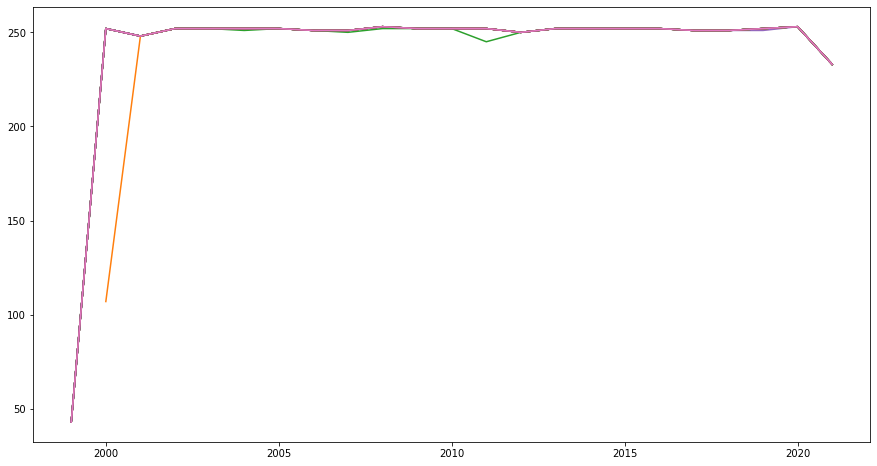

In [9]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

count_unique = 1
stocks_with_all_analysis_yrs = []
last = None

for i, (key, rows_dict) in enumerate(rows_per_year.items()):
  if all(analysis_year in rows_dict for analysis_year in analysis_years):
    stocks_with_all_analysis_yrs.append(key)
    if last is None: last = rows_dict
    elif rows_dict != last: count_unique += 1
    as_list = sorted(rows_dict.items())
    year, row_count = zip(*as_list)
    plt.plot(year, row_count)

print(len(stocks_with_all_analysis_yrs), "stocks have data in each of the years in", analysis_years)
print("There are", count_unique, "unique rows-per-year patterns among those stocks")

### Step 1: Visualize the time series data of adjusted closing price per day over this span.

In [91]:
combined_data = []
for i, data_file in enumerate(stocks_with_all_analysis_yrs):
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_month_cols(stock_data, "timestamp")
  stock_data = stock_data[stock_data.year.isin(analysis_years)]
  stock_data.reset_index(inplace = True)
  combined_data.append(stock_data)

combined_data = pd.concat(combined_data)
combined_data.drop(columns = "index", inplace = True)
combined_data.head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,timestamp_as_dt,year,month
0,USPH,2019-12-31,113.40,115.01,113.24,114.35,112.408365,122341,0.0,1.0,2019-12-31,2019,12
1,USPH,2019-12-30,113.98,114.16,112.30,113.86,111.926685,72785,0.0,1.0,2019-12-30,2019,12
2,USPH,2019-12-27,114.10,114.10,113.02,114.00,112.064308,78205,0.0,1.0,2019-12-27,2019,12
3,USPH,2019-12-26,115.22,116.69,113.25,113.98,112.044648,73688,0.0,1.0,2019-12-26,2019,12
4,USPH,2019-12-24,114.64,115.79,113.41,115.54,113.578159,30642,0.0,1.0,2019-12-24,2019,12


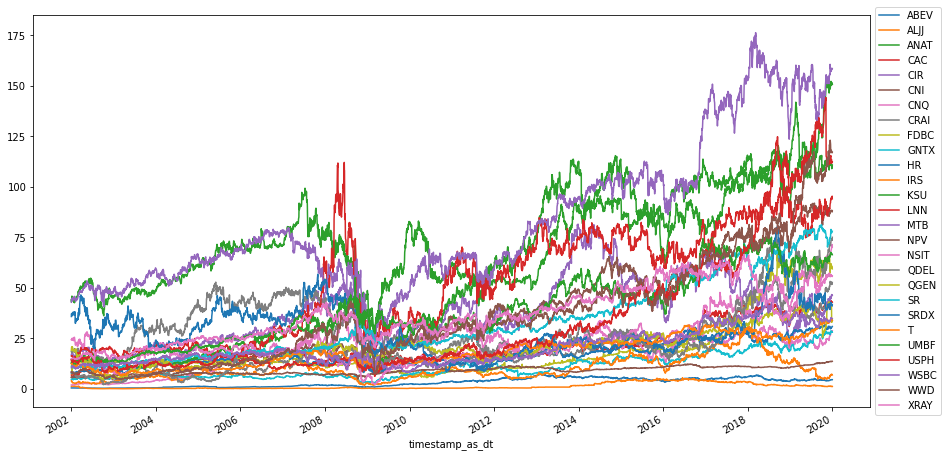

In [33]:
fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot( x='timestamp_as_dt', y='adjusted_close', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This plot clearly shows us that stock data over time is non-stationary. At the very least, the mean increases with time, but also the variance of the series appears time depenedent. However, the covariance *appears* to be constant with time.

#### Look at trends by month

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


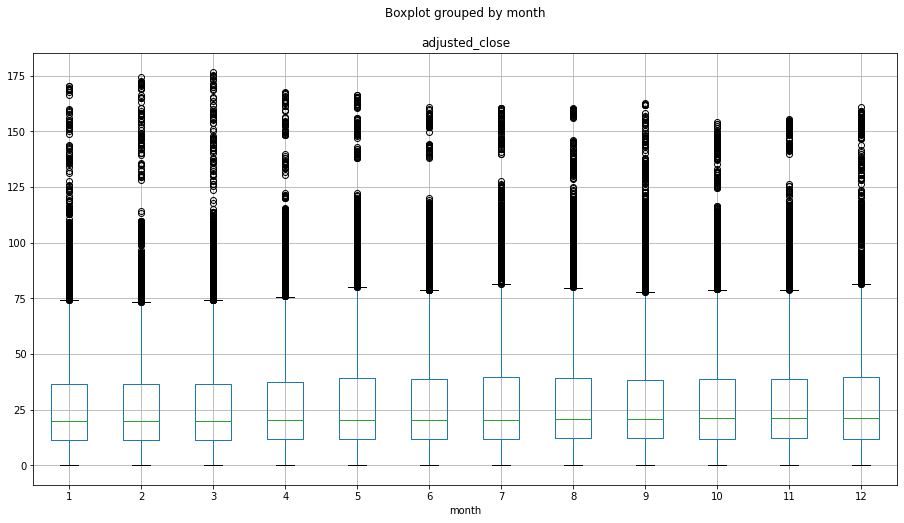

In [41]:
combined_data.boxplot(column = "adjusted_close", by = "month")

Looks like there are no seasonal trends.

Lets use Differencing and a Log transform to take out the trends and stabilize the variance in the data (i.e., make it stationary).

In [120]:
combined_data = combined_data.sort_values(by = ['symbol', 'timestamp_as_dt'])

combined_data['adjusted_close_log'] = np.log(combined_data['adjusted_close'])

combined_data['adjusted_close_log_diff'] = combined_data.groupby('symbol')['adjusted_close_log'].diff()

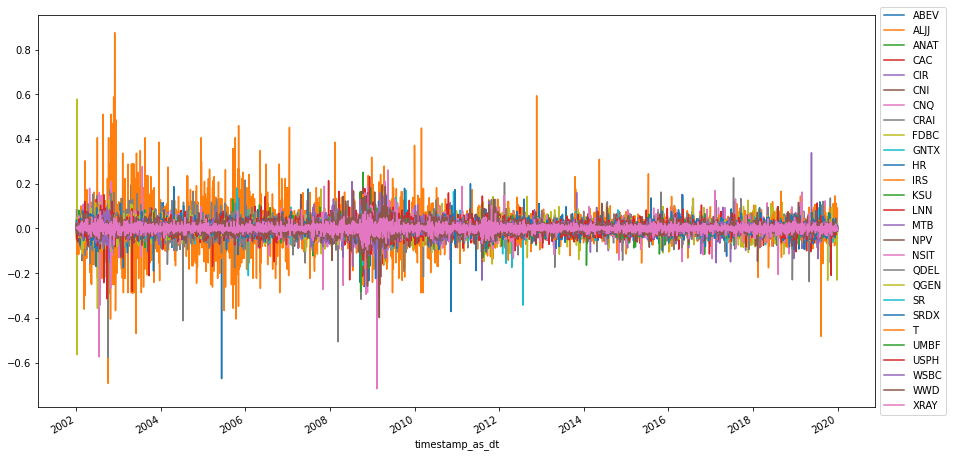

In [123]:
fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot(x='timestamp_as_dt', y='adjusted_close_log_diff', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
We will now look at the Autocorrelation plots to see which parameters we need to use in our time series model.

Stock data is typically an Autoregressive time series, so we use the PACF plot to check what the optimal lag parameter is. Looks like its `2`, i.e., this is an AR(2) process.

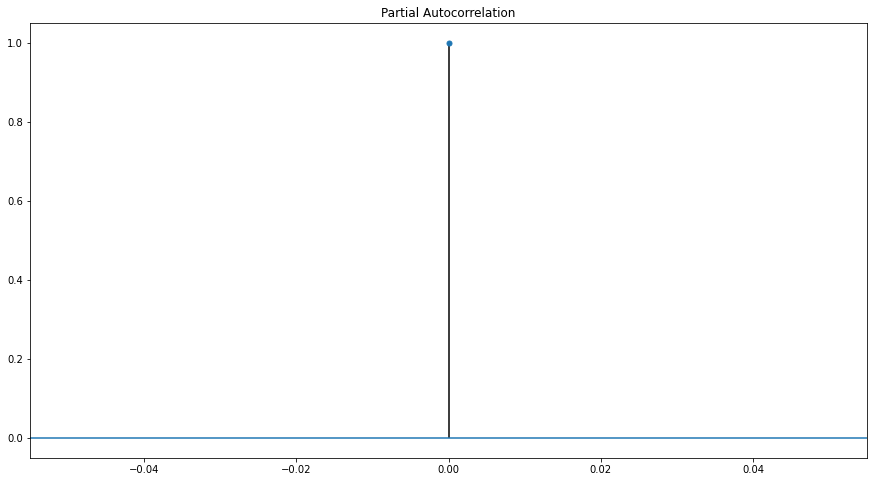

In [126]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(combined_data['adjusted_close_log_diff']);

### Step 2: Stationarize the series

Next we'll have to stationarize our time series data.

First we will log-transform the adjusted close price so that the variance can be stabilized.

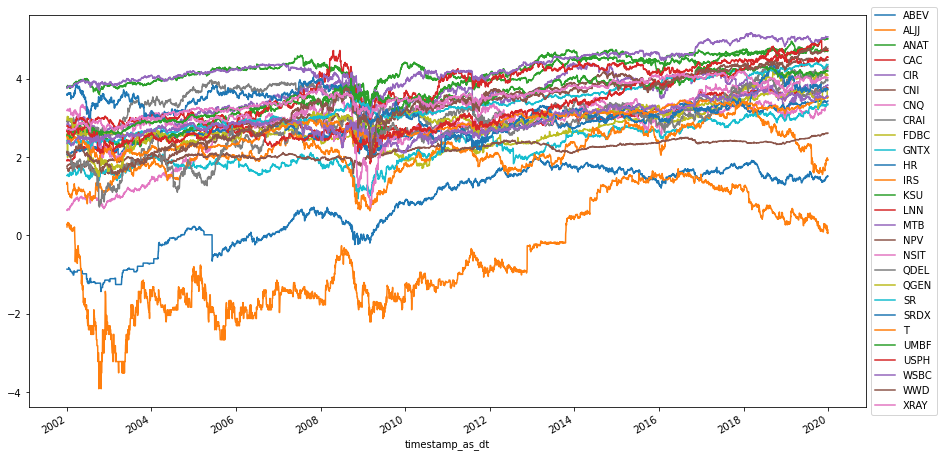

In [57]:
combined_data['adjusted_close_log'] = np.log(combined_data['adjusted_close'])

fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot( x='timestamp_as_dt', y='adjusted_close_log', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Next we will use differencing to stabilize the mean.

Hopefully this will result in a stationary series.

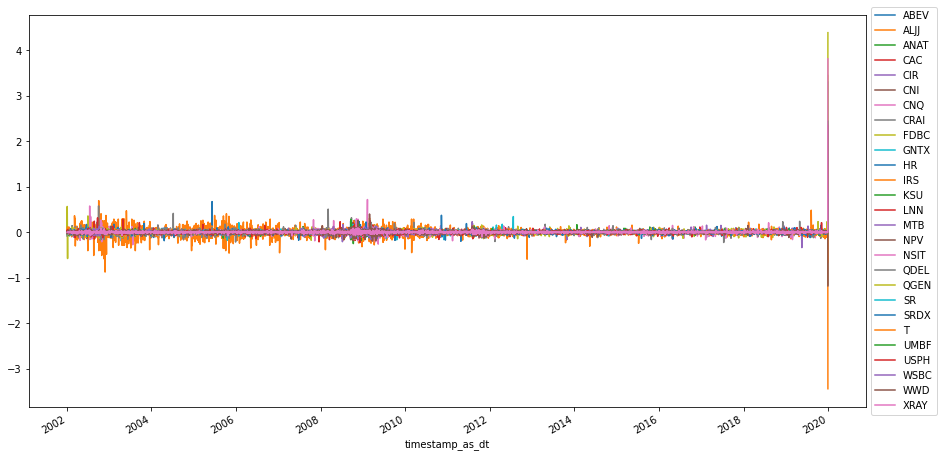

In [59]:
combined_data['adjusted_close_log_diff'] = combined_data['adjusted_close_log'].diff()

fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot( x='timestamp_as_dt', y='adjusted_close_log_diff', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Now we can take a look at the autocorrelation plots on our "adjusted_close" column. 

The ACF plot on the untransformed data looks like its telling us that this is a AR process. We can use the PACF plot to see what the lag is.

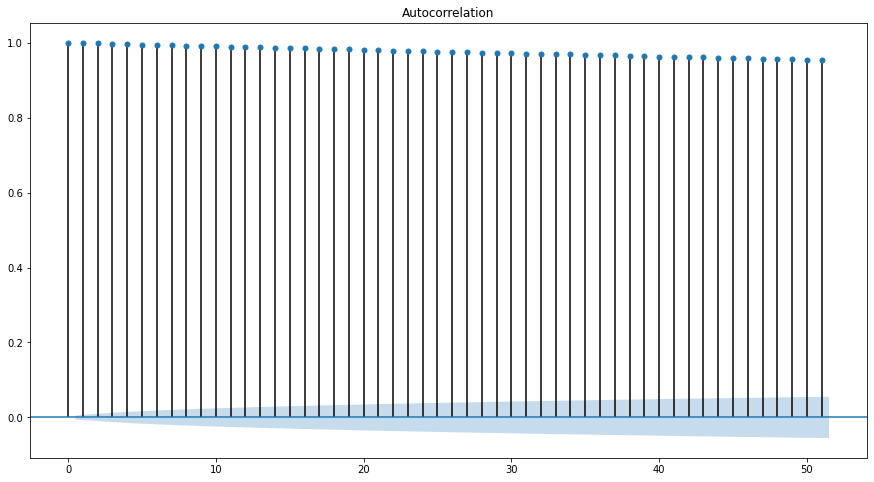

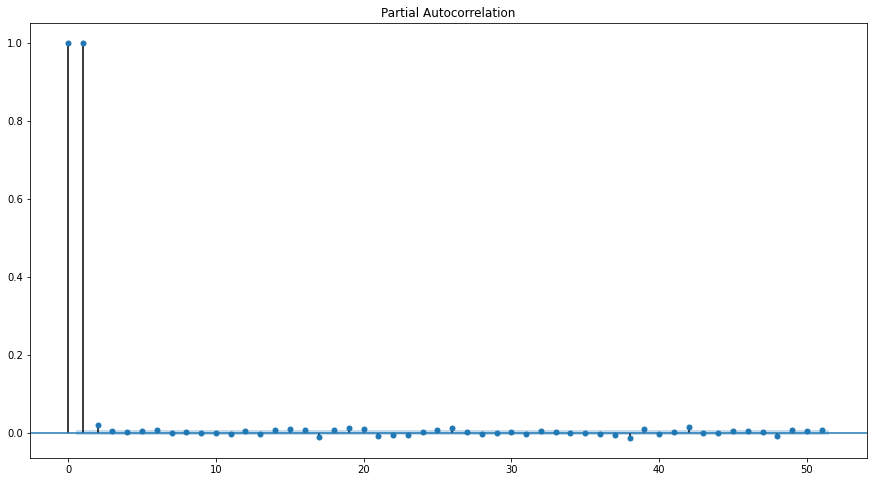

In [74]:
plot_pacf(combined_data['adjusted_close']);

### Step 3: Add features to stock price

Add independent variables into dataframe as features for one particular stock as an example.  
Try using pandas before running huge data in spark.  

In [ ]:
ticker = 'ABM.csv'                      # change ticker to try different stock

stock_data = pd.read_csv(os.path.join(in_dir, ticker)).copy()
stock_data = stock_data.drop(columns=['open', 'high', 'low', 'close', 'volume', 'dividend_amount', 'split_coefficient'])

technical_data = pd.read_csv(os.path.join(tech_dir, ticker)).copy()
technical_data = technical_data.drop(columns=['symbol'])

stock_df = pd.merge(stock_data, technical_data, on='timestamp')
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5501 entries, 0 to 5500
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symbol            5501 non-null   object 
 1   timestamp         5501 non-null   object 
 2   adjusted_close    5501 non-null   float64
 3   SMA               5501 non-null   float64
 4   EMA               5501 non-null   float64
 5   MACD              5501 non-null   float64
 6   MACD_Hist         5501 non-null   float64
 7   MACD_Signal       5501 non-null   float64
 8   SlowD             5501 non-null   float64
 9   SlowK             5501 non-null   float64
 10  RSI               5501 non-null   float64
 11  Real_Lower_Band   5501 non-null   float64
 12  Real_Middle_Band  5501 non-null   float64
 13  Real_Upper_Band   5501 non-null   float64
dtypes: float64(12), object(2)
memory usage: 644.6+ KB


### Step 4: Check correlation of stock and technical data to find pattern.  

Check correlation of stock and technical data.  
Plot the correlation matrix.  

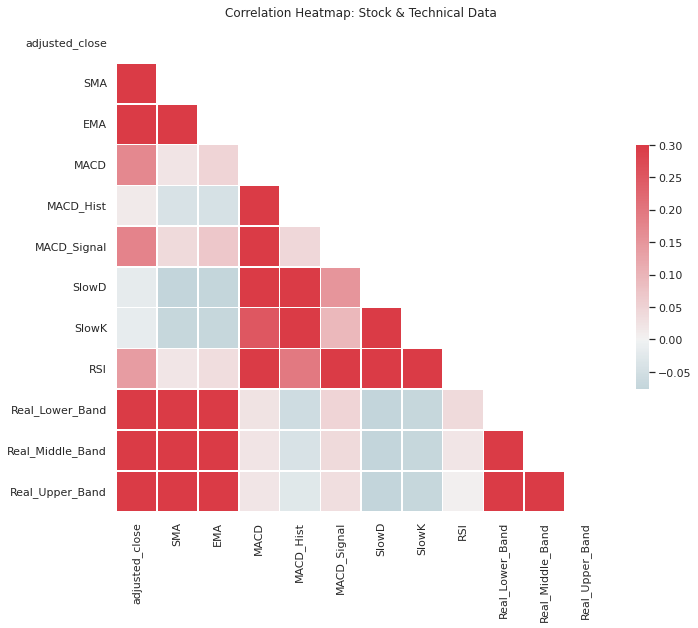

In [ ]:
corr = stock_df.corr(method ='pearson')

from string import ascii_letters

sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Stock & Technical Data")
plt.show()

Step 5: Run linear regression on adjusted_close with technical data features.  

In [ ]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

formula = 'adjusted_close ~ SMA + EMA + MACD + MACD_Hist + MACD_Signal + SlowD + SlowK + RSI + Real_Lower_Band + Real_Middle_Band + Real_Upper_Band'
model1 = smf.ols(formula=formula, data=stock_df).fit()
print(model1.params)
model1.summary()



Intercept           -3.919292
SMA                 44.312710
EMA                  1.087606
MACD                48.179520
MACD_Hist          -44.804852
MACD_Signal        -45.952384
SlowD               -0.013489
SlowK                0.015265
RSI                  0.073288
Real_Lower_Band    -44.345626
Real_Middle_Band    44.312710
Real_Upper_Band    -44.359599
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.287e+05
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:19:50   Log-Likelihood:                -2499.3
No. Observations:                5501   AIC:                             5021.
Df Residuals:                    5490   BIC:                             5093.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.9193      0.081    -48.256      0.000      -4.079      -3.760
SMA                 44.3127     73.101      0.606      0.544     -98.995     187.620
EMA                  1.0876      0.024     45.891      0.000       1.041       1.134
MACD                48.1795    101.921      0.473      0.636    -151.627     247.986
MACD_Hist          -44.8049    101.921     -0.440      0.660    -244.611     155.001
MACD_Signal        -45.9524    101.922     -0.451      0.652    -245.760     153.855
SlowD               -0.0135      0.001    -25.652      0.000      -0.015      -0.012
SlowK                0.0153      0.000     32.255      0.000       0.014       0.016
RSI                  0.0733      0.002     44.082      0.000       0.070       0.077
Real_Lower_Band    -44.3456     73.101     -0.607      0.544    -187.653      98.961
Real_Middle_Band    44.3127     73.101      0.606      0.544     -98.995     187.620
Real_Upper_Band    -44.3596     73.101     -0.607      0.544    -187.667      98.947
==============================================================================
Omnibus:                     1089.517   Durbin-Watson:                   0.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34536.237
Skew:                           0.103   Prob(JB):                         0.00
Kurtosis:                      15.273   Cond. No.                     1.36e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.35e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Step 6: Divide the dataset into training and testing.  Run linear regression model on training dataset and evaluate the model on testing dataset.  

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing

train, test = train_test_split(stock_df, test_size=0.20, random_state=42)

list_of_features = ['SMA','EMA','MACD','MACD_Hist','MACD_Signal','SlowD','SlowK','RSI','Real_Lower_Band','Real_Middle_Band','Real_Upper_Band']
X_train = train[list_of_features]
y_train = train[['adjusted_close']]
X_test = test[list_of_features]
y_test = test[['adjusted_close']]

# Run linear regression model on training dataset and then test model

model2 = smf.ols(formula=formula, data=train).fit()
y_pred = model2.predict(X_test)

# Evaluate performance of linear regression model

print('R Squared =', model2.rsquared)
print('R Squared_adj =', model2.rsquared_adj)
print('MAE =', mean_absolute_error(y_test, y_pred))
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', np.sqrt(mean_squared_error(y_test, y_pred)))


R Squared = 0.9987284873094353
R Squared_adj = 0.9987255902652554
MAE = 0.2591705707442236
MSE = 0.15748895276002223
RMSE = 0.3968487782014986
